In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

from math import floor,ceil,sqrt
import sys
import warnings
import datetime as dt

if not sys.warnoptions:
    warnings.simplefilter("ignore")
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


In [2]:
df = pd.read_csv('Microsoft_Stock.csv')
df.head(8)

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438
5,4/9/2015 16:00:00,41.25,41.62,41.25,41.48,25723861
6,4/10/2015 16:00:00,41.63,41.95,41.41,41.72,28022002
7,4/13/2015 16:00:00,41.40,42.06,41.39,41.76,30276692


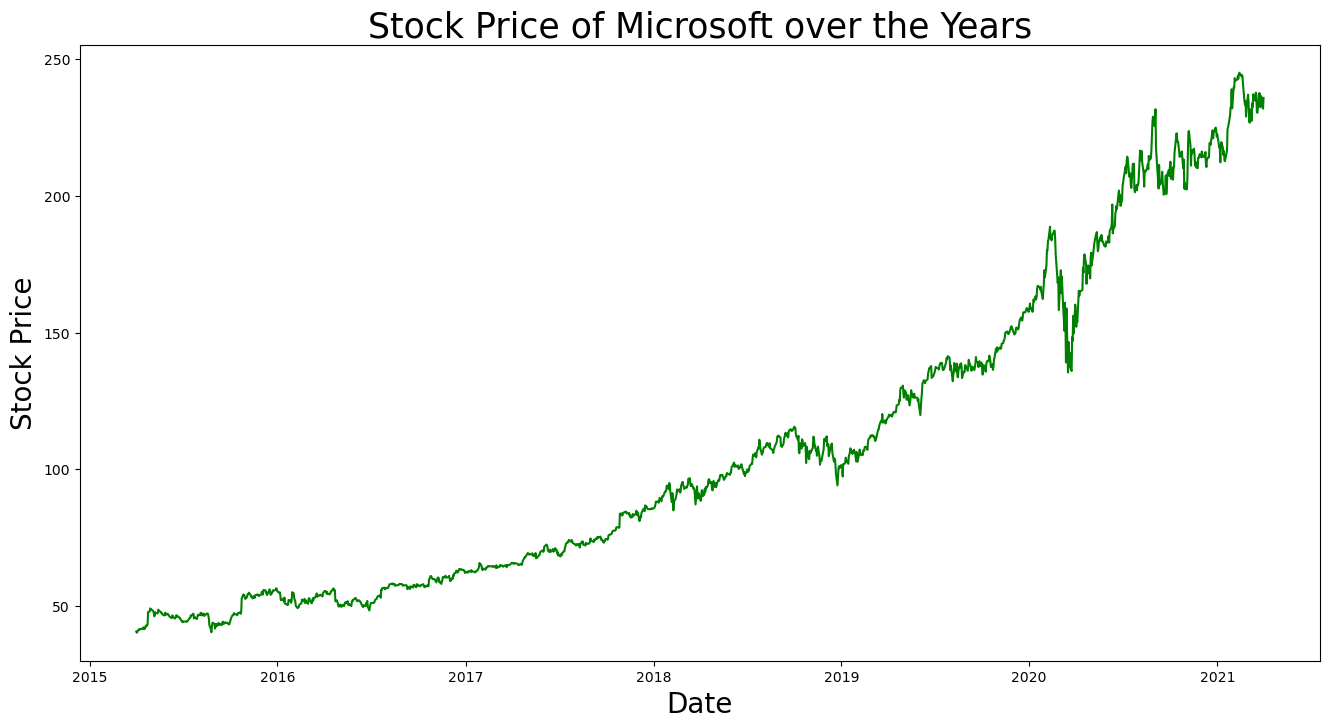

In [3]:
df['Date'] = pd.to_datetime(df.Date,format='%m/%d/%Y %H:%M:%S')
df.index = df['Date']
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history',color='g')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price of Microsoft over the Years',size=25)
plt.show()

# Moving Average

In [6]:
def moving_avg_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-----------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY MOVING AVERAGE--------')
    print('-----------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    preds = []
    for i in range(0,valid_set.shape[0]):
        a = train_set['Close'][len(train_set)-valid_set.shape[0]+i:].sum() + sum(preds)
        b = a/(valid_set.shape[0])
        preds.append(b)
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['Close'])-preds),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = preds
    plt.plot(train_set['Close'])
    plt.plot(valid_set[['Close', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Moving Averages',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()

-----------------------------------------------------------
-----------STOCK PRICE PREDICTION BY MOVING AVERAGE--------
-----------------------------------------------------------
Shape of Training Set (1134, 1)
Shape of Validation Set (377, 1)
RMSE value on validation set: 76.62376749929759
-----------------------------------------------------------
-----------------------------------------------------------


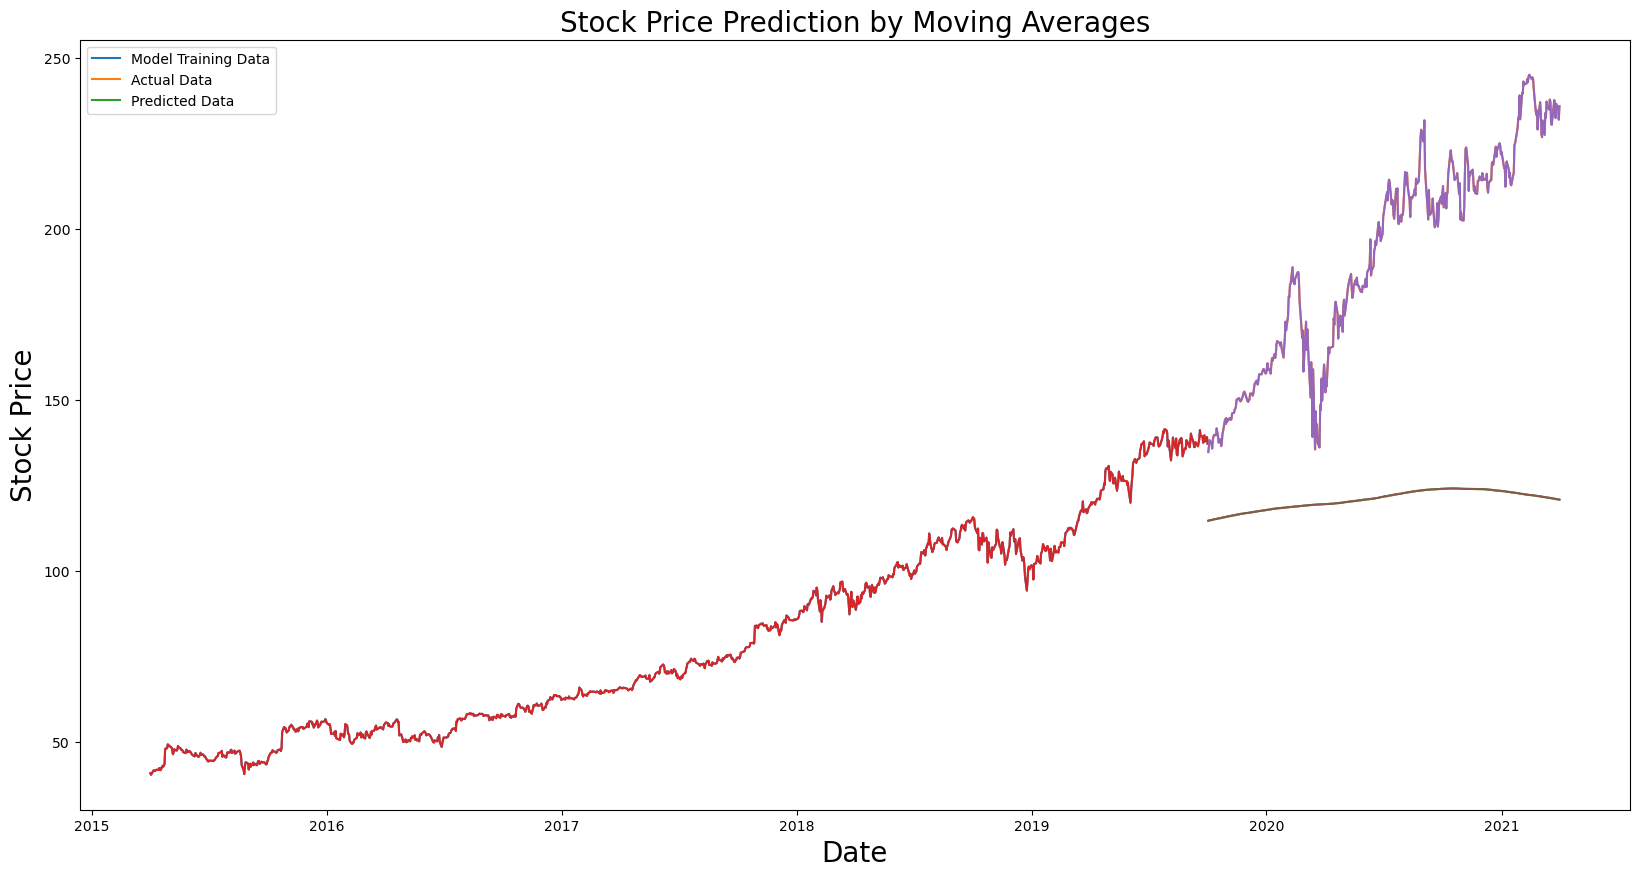

In [7]:
moving_avg_prediction(df)

# Linear Regression

In [8]:
def linear_regression_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-----------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY LINEAR REGRESSION-----------')
    print('-----------------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    train=train_set.reset_index()
    valid=valid_set.reset_index()
    x_train = train['Date'].map(dt.datetime.toordinal)
    y_train = train[['Close']]
    x_valid = valid['Date'].map(dt.datetime.toordinal)
    y_valid = valid[['Close']]
    #implement linear regression
    model = LinearRegression()
    model.fit(np.array(x_train).reshape(-1,1),y_train)
    preds = model.predict(np.array(x_valid).reshape(-1,1))
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['Close'])-preds),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = preds
    plt.plot(train_set['Close'])
    plt.plot(valid_set[['Close', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Linear Regression',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()

-----------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LINEAR REGRESSION-----------
-----------------------------------------------------------------
Shape of Training Set (1134, 1)
Shape of Validation Set (377, 1)
RMSE value on validation set: 58.36609230803425
-----------------------------------------------------------
-----------------------------------------------------------


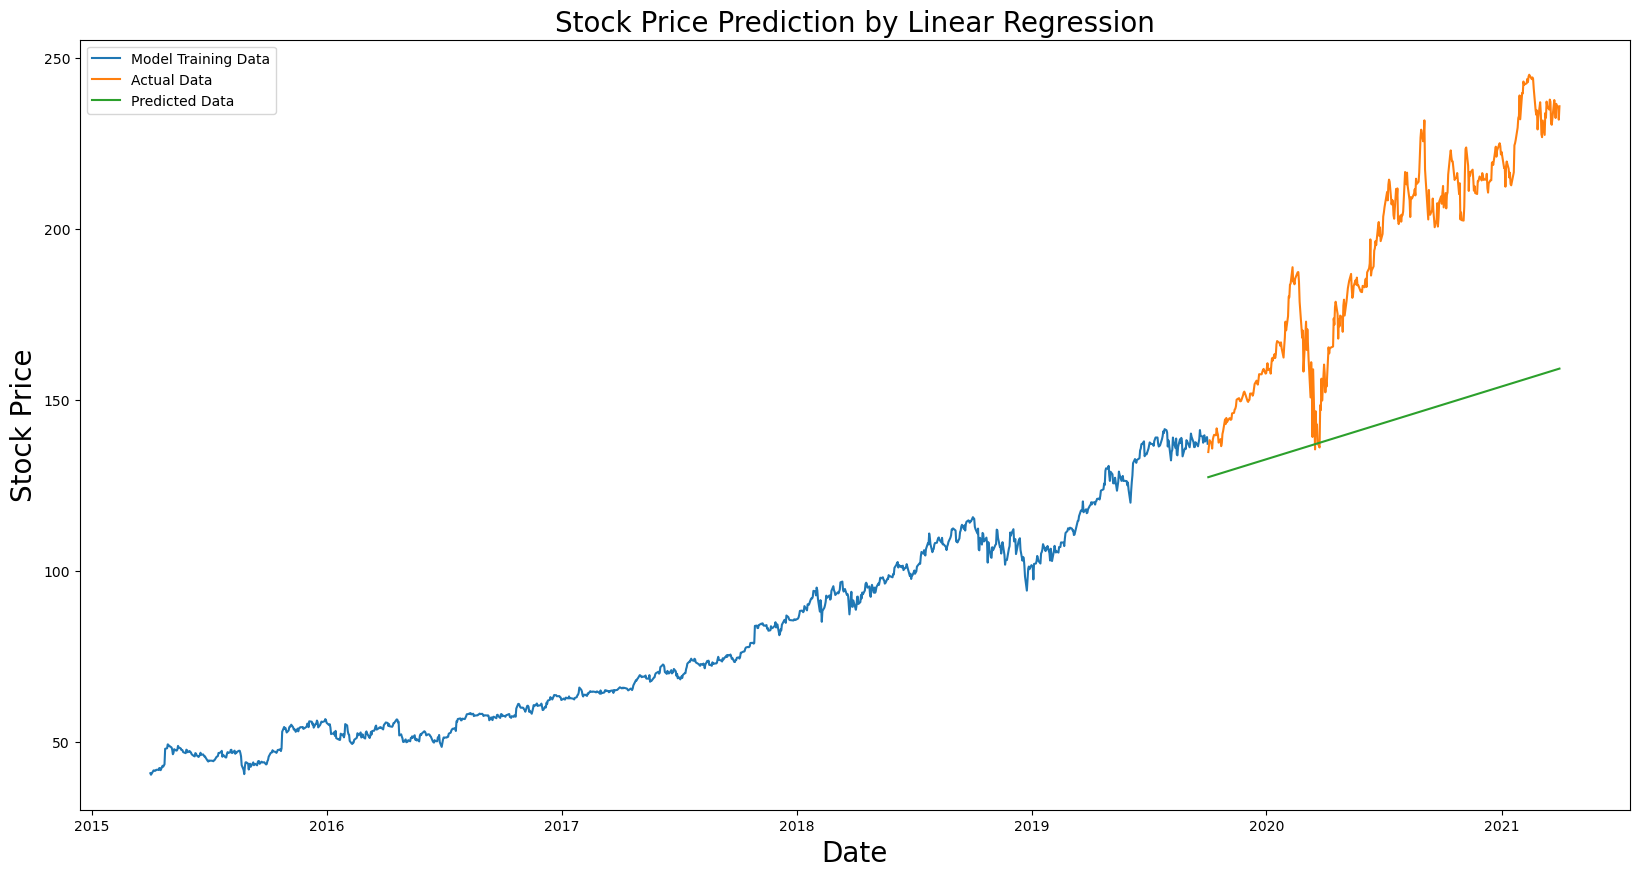

In [10]:
linear_regression_prediction(df)

# K-Nearest Neighbours

In [11]:
def k_nearest_neighbours_predict(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-------------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY K-NEAREST NEIGHBORS-----------')
    print('-------------------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    train=train_set.reset_index()
    valid=valid_set.reset_index()
    x_train = train['Date'].map(dt.datetime.toordinal)
    y_train = train[['Close']]
    x_valid = valid['Date'].map(dt.datetime.toordinal)
    y_valid = valid[['Close']]
    x_train_scaled = scaler.fit_transform(np.array(x_train).reshape(-1, 1))
    x_train = pd.DataFrame(x_train_scaled)
    x_valid_scaled = scaler.fit_transform(np.array(x_valid).reshape(-1, 1))
    x_valid = pd.DataFrame(x_valid_scaled)
    params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
    knn = neighbors.KNeighborsRegressor()
    model = GridSearchCV(knn, params, cv=5)
    model.fit(x_train,y_train)
    preds = model.predict(x_valid)
    rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = preds
    plt.plot(train_set['Close'])
    plt.plot(valid_set[['Close', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by K-Nearest Neighbors',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()

-------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY K-NEAREST NEIGHBORS-----------
-------------------------------------------------------------------
Shape of Training Set (1134, 1)
Shape of Validation Set (377, 1)
RMSE value on validation set: 112.9467566922719
-----------------------------------------------------------
-----------------------------------------------------------


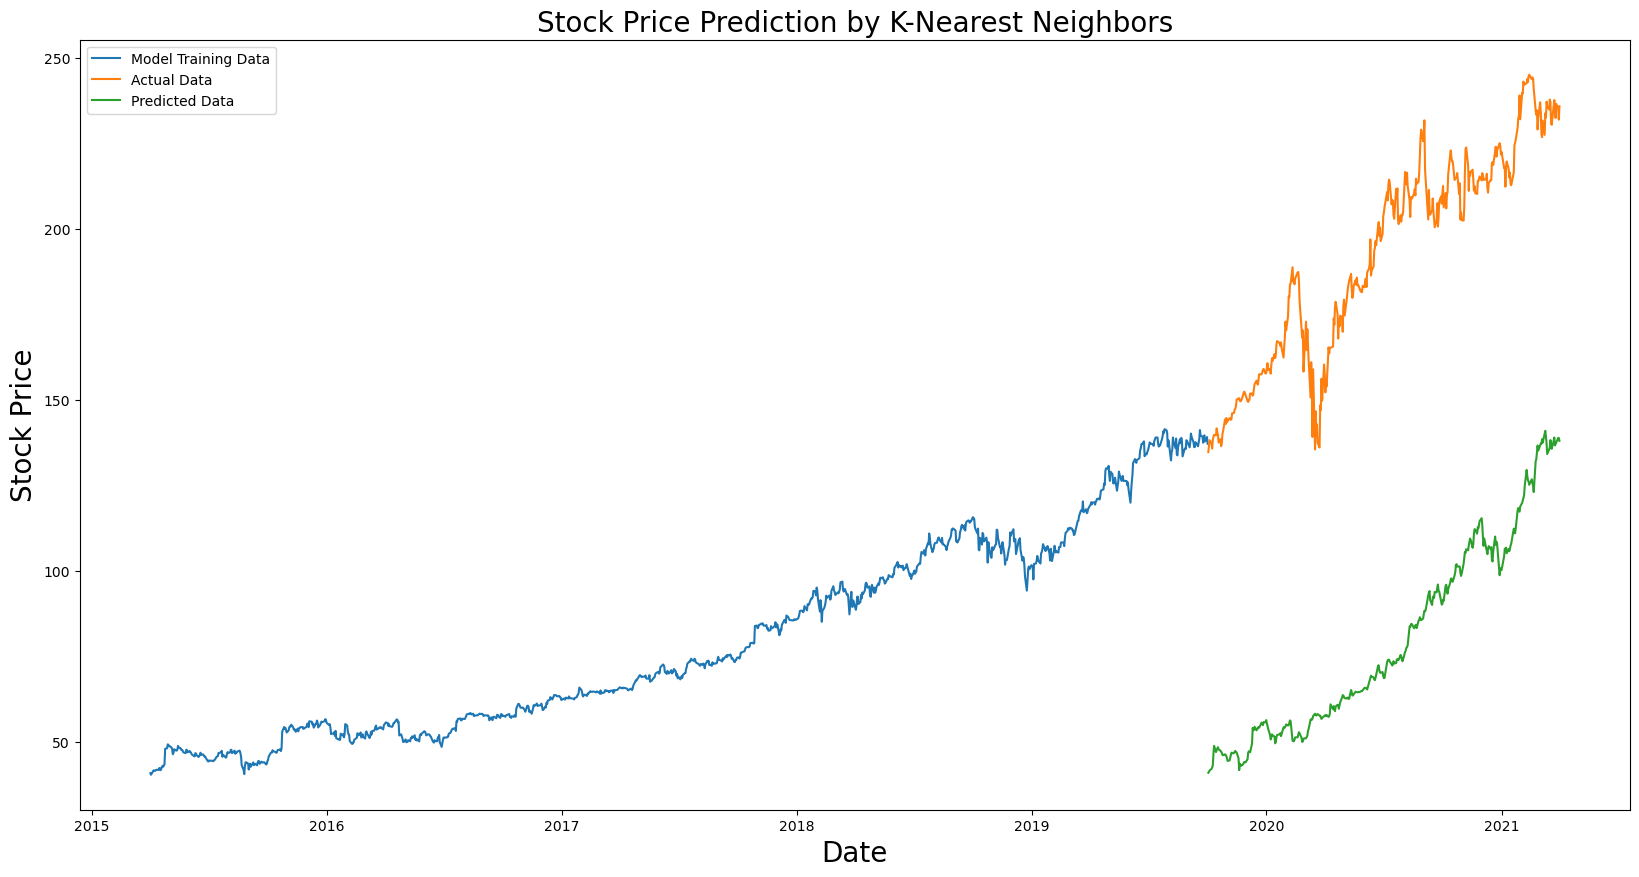

In [12]:
k_nearest_neighbours_predict(df)

# Auto ARIMA

In [17]:
def auto_arima_prediction(df):
    shape = df.shape[0]
    df_new = df.copy()

    # Ensure the index is datetime
    df_new.index = pd.to_datetime(df_new.index, errors='coerce')
    if df_new.index.isnull().any():
        raise ValueError("Index must be a valid datetime. Check your data.")

    data = df_new.sort_index(ascending=True, axis=0)
    train_set = data[:ceil(shape * 0.75)]
    valid_set = data[ceil(shape * 0.75):]

    print('----------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY AUTO ARIMA-----------')
    print('----------------------------------------------------------')
    print('Shape of Training Set', train_set.shape)
    print('Shape of Validation Set', valid_set.shape)

    training = train_set['Close']
    validation = valid_set['Close']

    model = auto_arima(
        training, start_p=1, start_q=1, max_p=3, max_q=3,
        m=12, start_P=0, seasonal=True, d=1, D=1,
        trace=True, error_action='ignore', suppress_warnings=True
    )
    model.fit(training)

    forecast = model.predict(n_periods=len(valid_set))

    # Align forecast with validation index
    forecast = pd.DataFrame(
        forecast, index=valid_set.index[:len(forecast)], columns=['Prediction']
    )

    # Calculate RMSE
    rms = np.sqrt(np.mean(np.power(
        np.array(valid_set['Close'][:len(forecast)]) - np.array(forecast['Prediction']), 2
    )))
    print('RMSE value on validation set:', rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    # Plot results
    plt.plot(train_set['Close'])
    plt.plot(valid_set['Close'])
    plt.plot(forecast['Prediction'])
    plt.xlabel('Date', size=20)
    plt.ylabel('Stock Price', size=20)
    plt.title('Stock Price Prediction by Auto ARIMA', size=20)
    plt.legend(['Model Training Data', 'Actual Data', 'Predicted Data'])
    plt.show()


----------------------------------------------------------
-----------STOCK PRICE PREDICTION BY AUTO ARIMA-----------
----------------------------------------------------------
Shape of Training Set (1134, 6)
Shape of Validation Set (377, 6)
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.86 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4440.431, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4126.393, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.48 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4427.420, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3999.903, Time=0.39 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.49 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.73 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4015.175, Time=0.35 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=3983.513, Time=0.58 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4107.542, Time=0.35 se

C:\Users\User\anaconda3\envs\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


RMSE value on validation set: nan
-----------------------------------------------------------
-----------------------------------------------------------


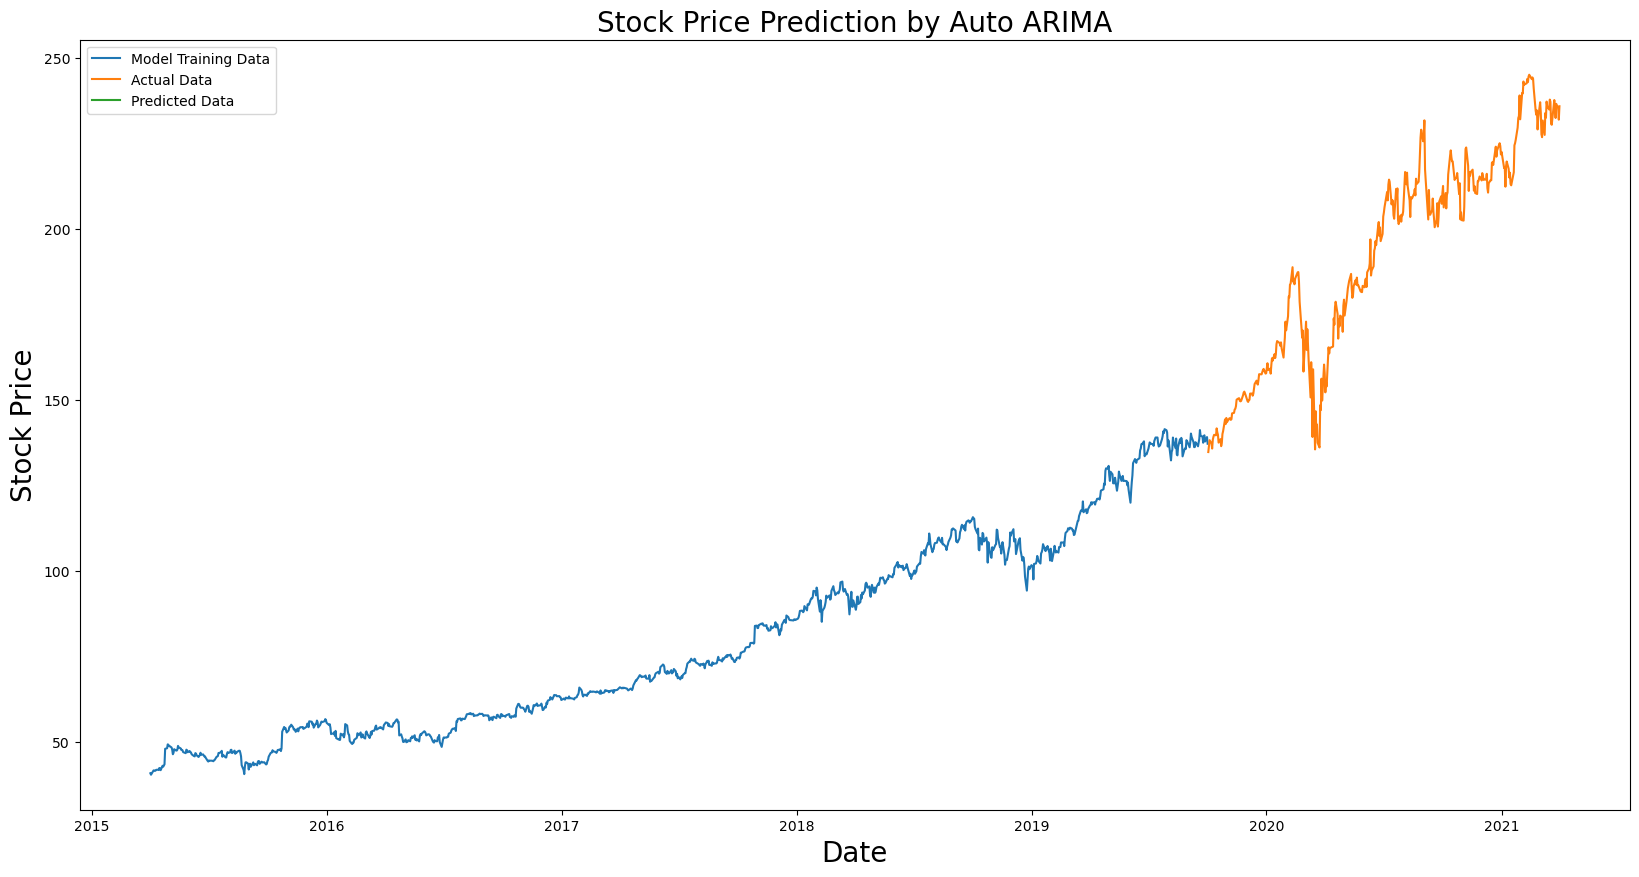

In [18]:
auto_arima_prediction(df)

# Prophet

In [19]:
def fb_prophet_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.reset_index(inplace=True)
    df_new['Date'] = pd.to_datetime(df_new.Date,format='%Y-%m-%d')
    df_new.index = df_new['Date']
    df_new.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY FB PROPHET-----------')
    print('-------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    model = Prophet()
    model.fit(train_set)
    close_prices = model.make_future_dataframe(periods=len(valid_set))
    forecast = model.predict(close_prices)
    forecast_valid = forecast['yhat'][ceil(shape*0.75):]
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['y'])-np.array(forecast_valid)),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = forecast_valid.values
    plt.plot(train_set['y'])
    plt.plot(valid_set[['y', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by FB Prophet',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()

-------------------------------------------------------
-----------STOCK PRICE PREDICTION BY FB PROPHET-----------
-------------------------------------------------------
Shape of Training Set (1134, 2)
Shape of Validation Set (377, 2)


09:53:17 - cmdstanpy - INFO - Chain [1] start processing
09:53:18 - cmdstanpy - INFO - Chain [1] done processing


RMSE value on validation set: 68.56866130702258
-----------------------------------------------------------
-----------------------------------------------------------


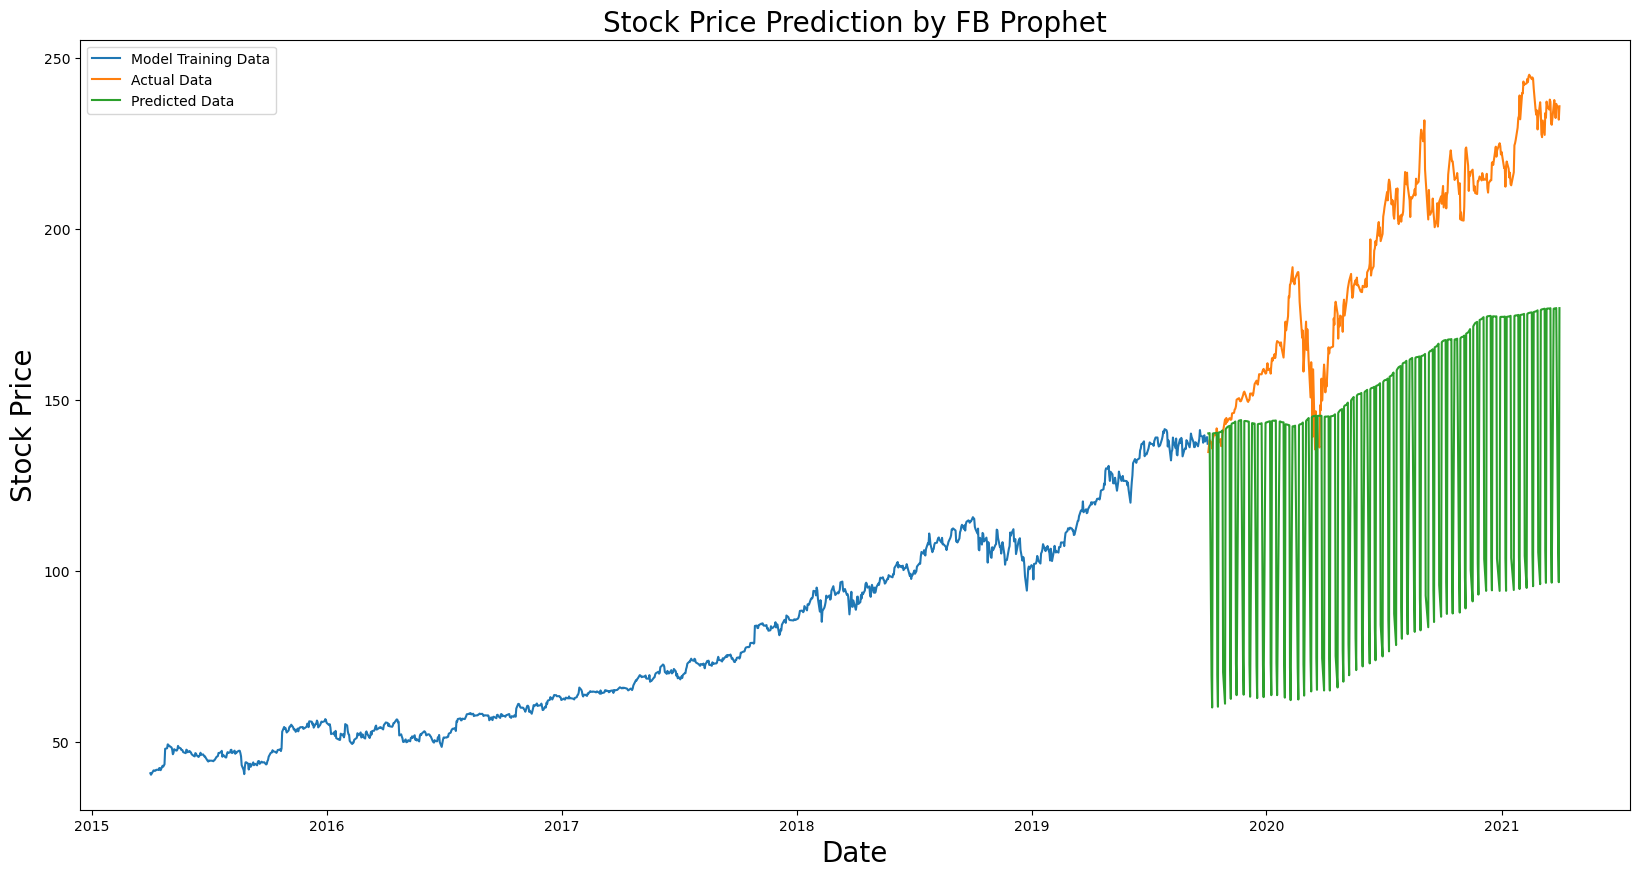

In [20]:
fb_prophet_prediction(df)

# Long Short Term Memory (LSTM)

In [21]:
def lstm_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    dataset = df_new.values
    train=df_new[:ceil(shape*0.75)]
    valid=df_new[ceil(shape*0.75):]
    print('-----------------------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('-----------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid['Predictions'] = closing_price
    plt.plot(train['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()

-----------------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
-----------------------------------------------------------------------------
Shape of Training Set (1134, 1)
Shape of Validation Set (377, 1)
1094/1094 - 16s - 14ms/step - loss: 5.7594e-04
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
RMSE value on validation set: 9.082141610284358
-----------------------------------------------------------
-----------------------------------------------------------


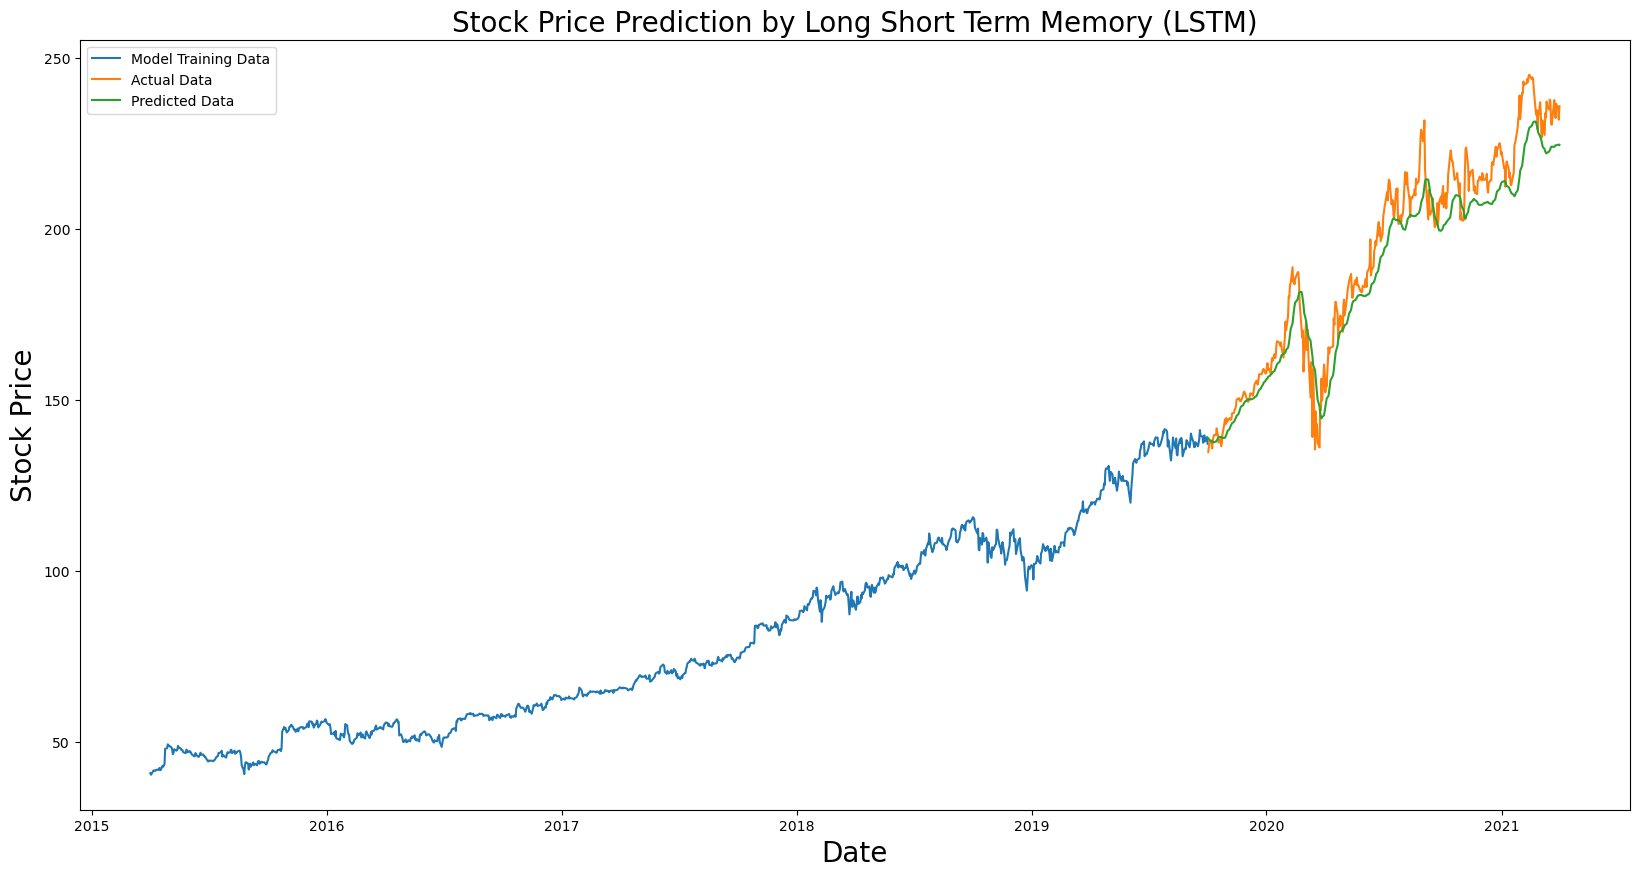

In [22]:
lstm_prediction(df)